In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns_c = sns.color_palette()


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing
from scipy import signal
from xgboost import XGBRegressor
%matplotlib inline

# If you want a style choose one
plt.style.use('Solarize_Light2')
plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'




import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_pickle('/Users/haribhaskar/Desktop/neuefische_course/EES_Optimisation/data/final_dataframe-2.pkl')
df = df.set_index('Date')
df.tail()

,Photovoltaics [MWh] Original resolutions,Photovoltaics [MW] Calculated resolutions,Total (grid load) [MWh] Original resolutions,Germany/Luxembourg [€/MWh] Calculated resolutions,normalisation_factor,Solar_generation_MWh_normalized
Date,,,,,,
2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.0,0.0
2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.0,0.0
2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.0,0.0
2023-06-01 23:30:00,0.0,62579.0,12371.00,86.53,1.0,0.0
2023-06-01 23:45:00,0.0,62579.0,12176.75,86.53,1.0,0.0


In [5]:
df = df.rename(columns={'Germany/Luxembourg [€/MWh] Calculated resolutions' : 'Price',
        'Total (grid load) [MWh] Original resolutions' : 'Actual_consumption',
        'Photovoltaics [MWh] Original resolutions': 'Solar_act_consumption',
        'Photovoltaics [MW] Calculated resolutions' : 'Installed_capacity'},
        )


# Train/Test Split

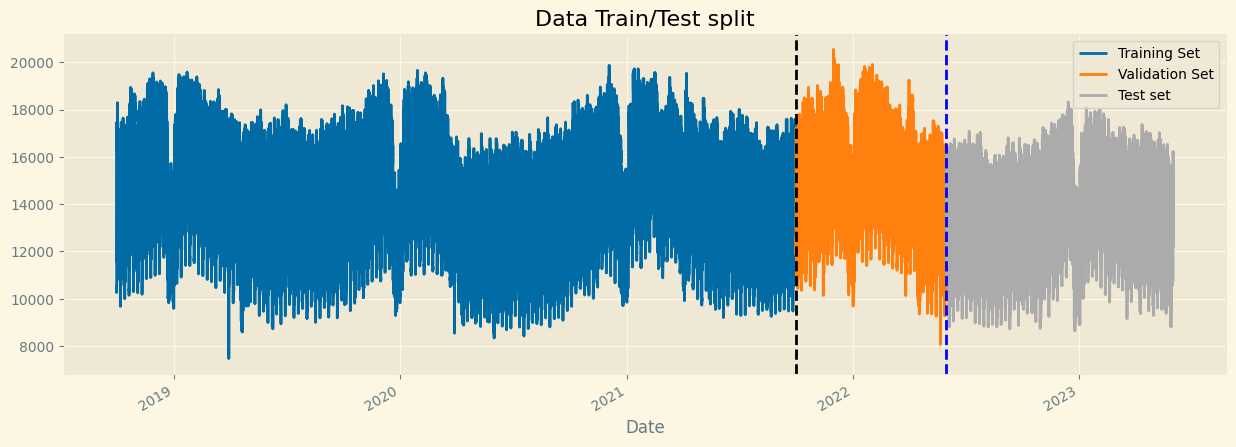

In [6]:
data = pd.DataFrame(data= df,columns=['Actual_consumption'])
train = data.loc[(data.index < '2021-10-01')]
val = data.loc[(data.index >='2021-10-01') & (data.index < '2022-05-31')]
test = data.loc[data.index >= '2022-06-01']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training set', title='Data Train/Test split' )
val.plot(ax=ax, label ='Validation set' )
test.plot(ax=ax, label ='Test set' )
ax.axvline('2021-10-01', color= 'black', ls = '--')
ax.axvline('2022-05-31', color= 'blue', ls = '--')
ax.legend (['Training Set', 'Validation Set', 'Test set'])
plt.show()

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=4*24*182,gap=4*24)
data = data.sort_index()

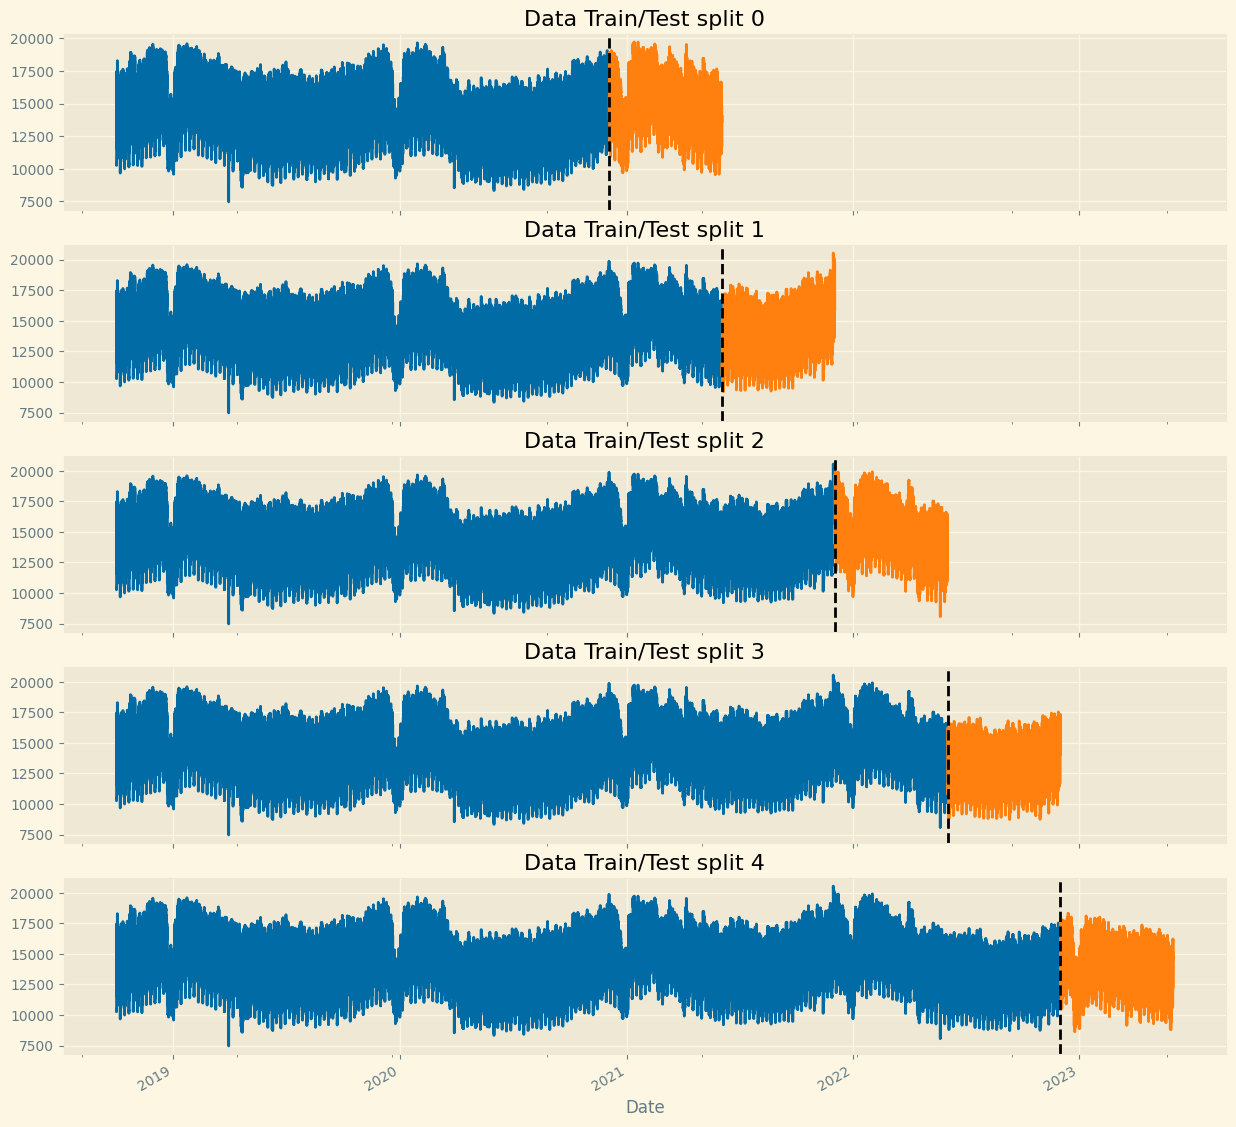

In [10]:
fig,axs = plt.subplots(5,1,figsize=(15,15),
                        sharex=True)
fold = 0
for train_idx, val_idx in tss.split(data):
    train_cv = data.iloc[train_idx]
    test_cv = data.iloc[val_idx]
    train_cv['Actual_consumption'].plot(ax=axs[fold], label = 'Training set', title=f'Data Train/Test split {fold}')
    test_cv['Actual_consumption'].plot(ax=axs[fold], label ='Test set' )
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    fold += 1


In [11]:
train_cv.head()

,Actual_consumption
Date,
2018-10-01 00:00:00,10589.75
2018-10-01 00:15:00,10589.75
2018-10-01 00:30:00,10589.75
2018-10-01 00:45:00,10589.75
2018-10-01 01:00:00,10589.75


# Decomposition using various parameters viz, Solar generation, Consumption and Market price

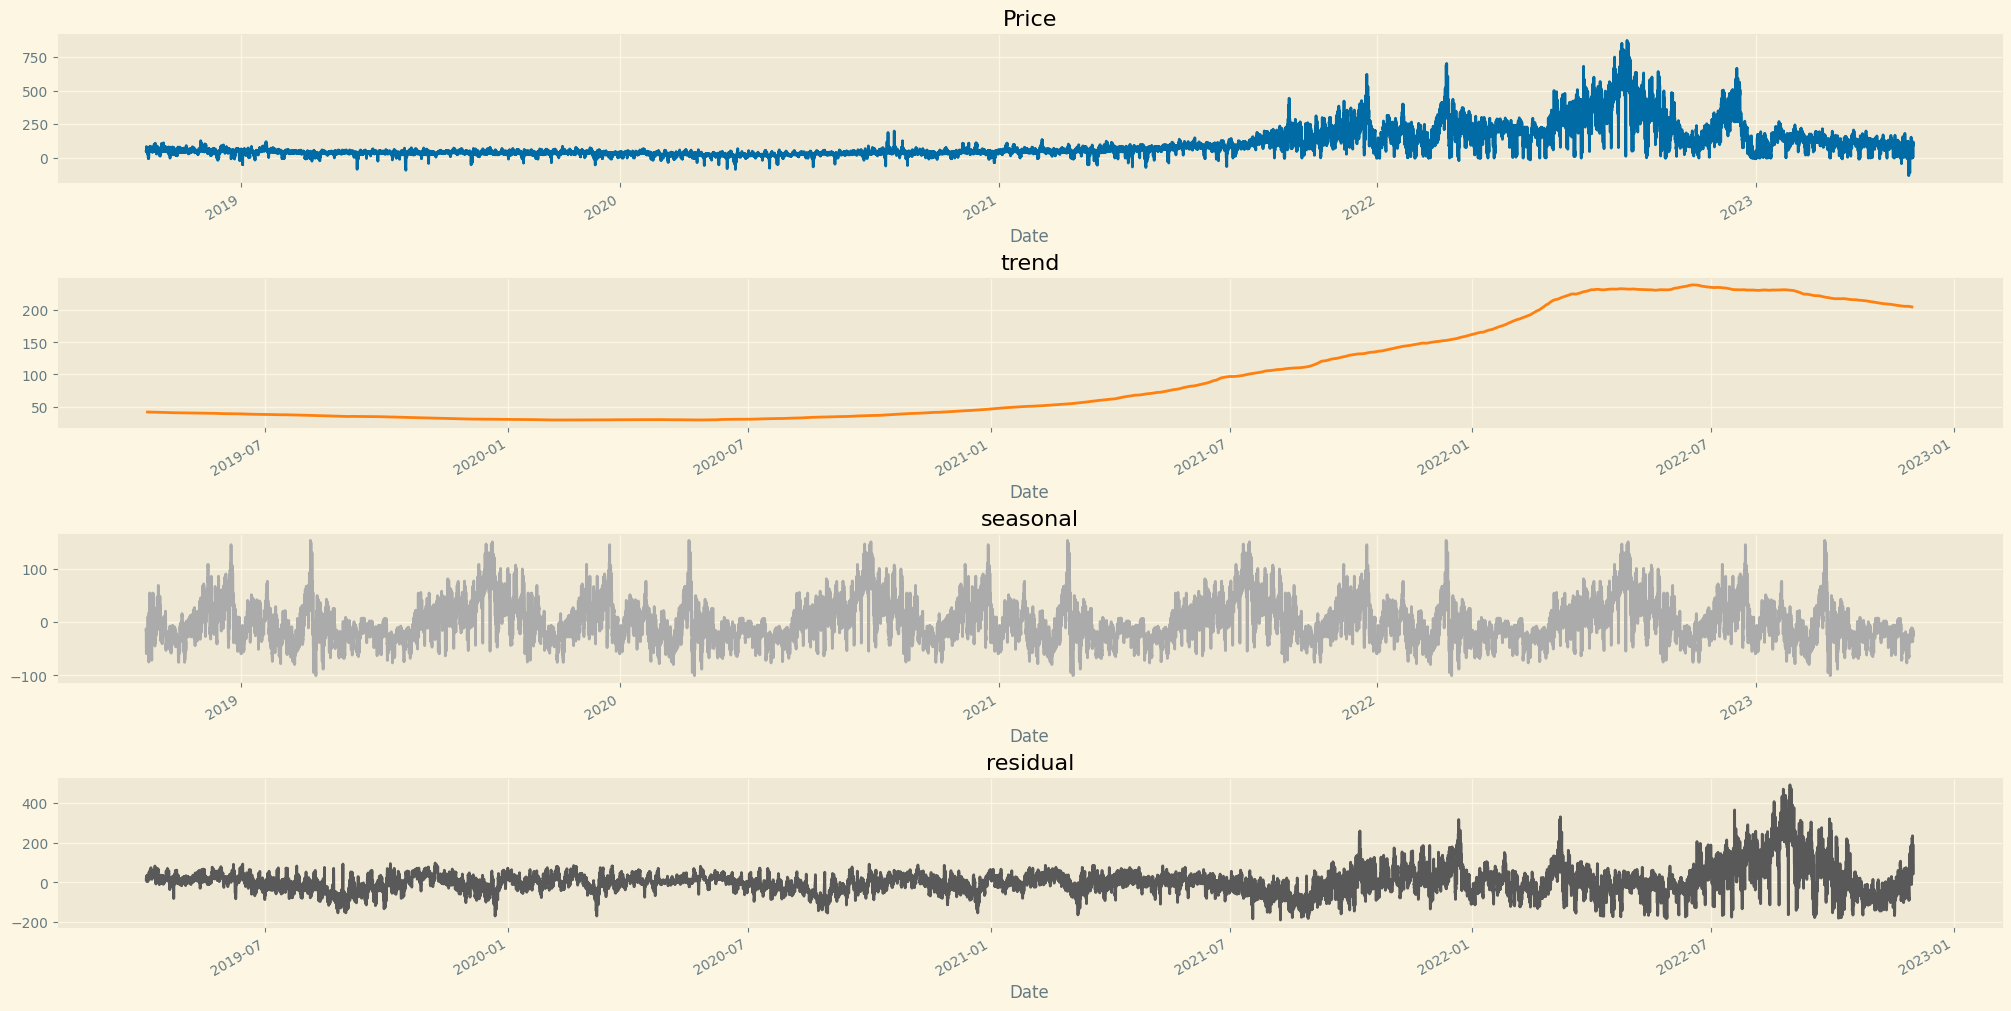

In [15]:

# Check decomposition of trend, seasonality and residue of original time series and Electricity market price
decomposition = seasonal_decompose(x=df['Price'], 
                                   model='additive',
                                   period=35064)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Price')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

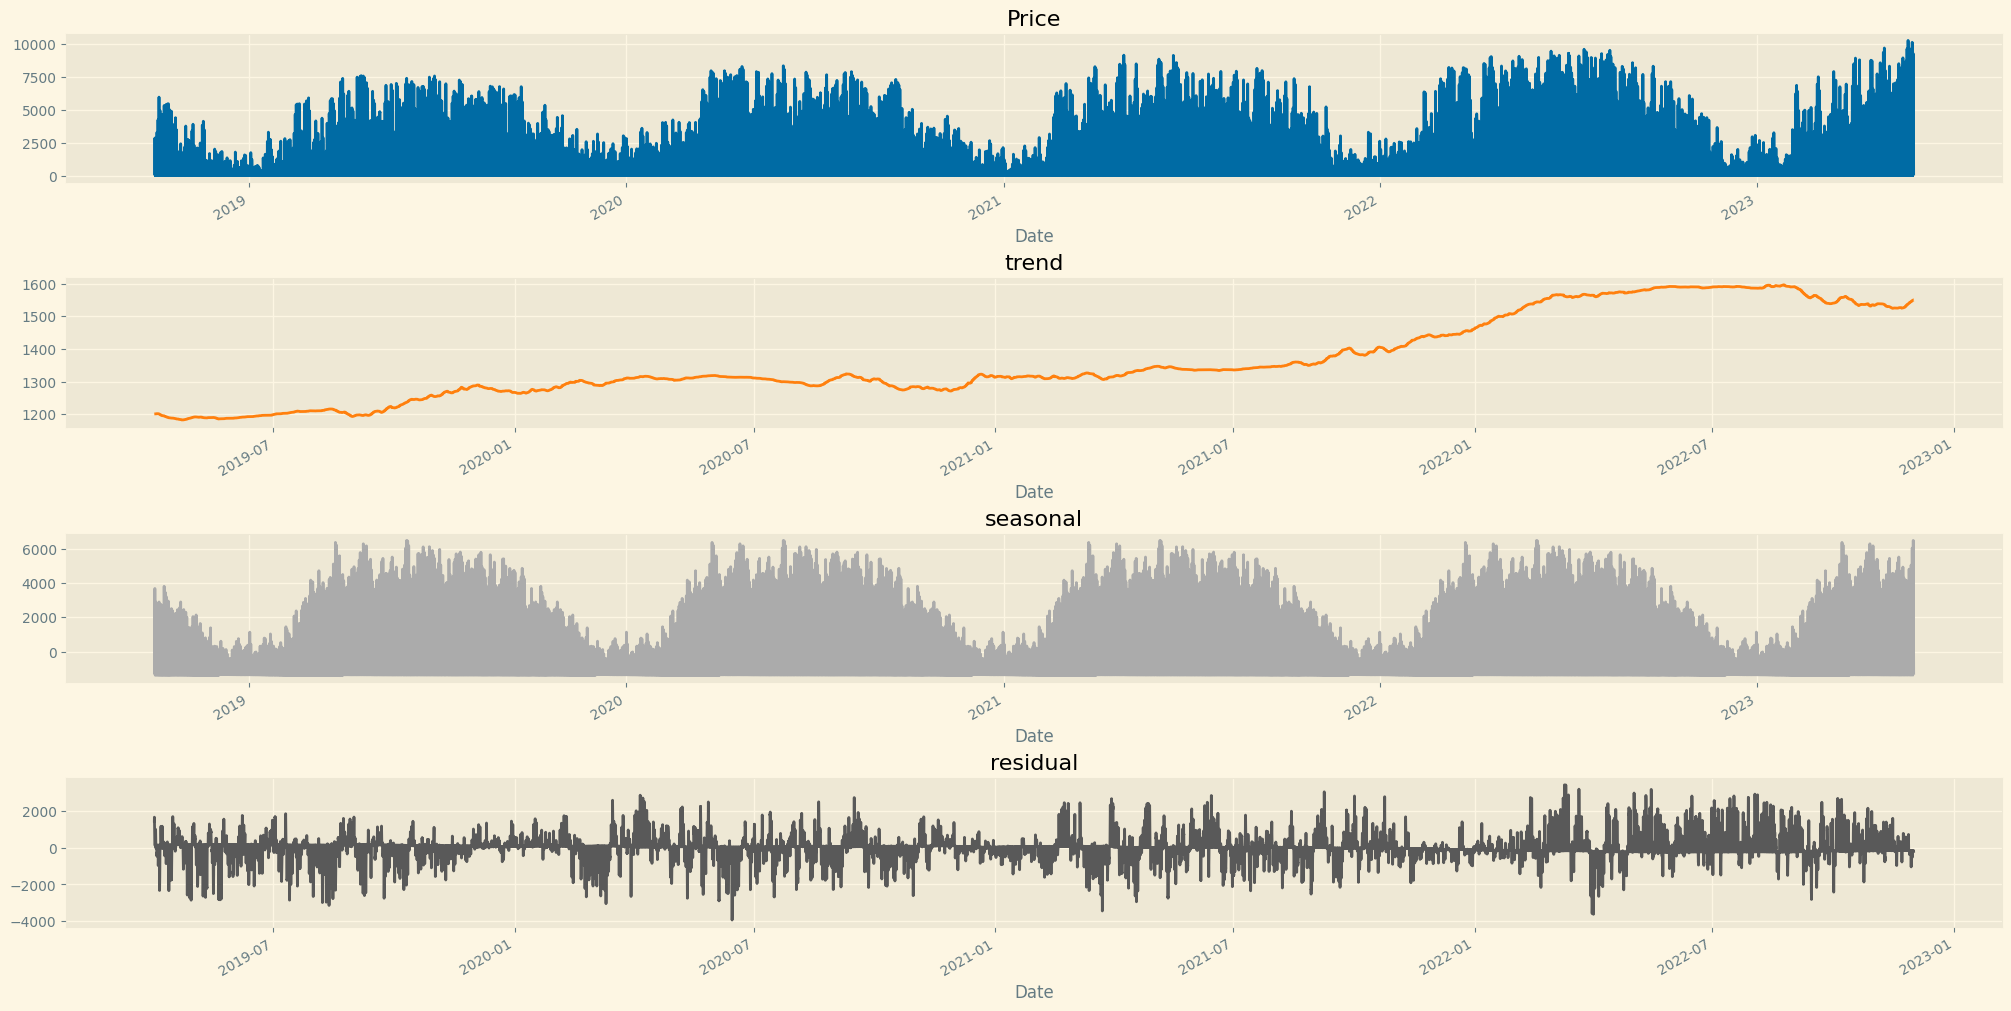

In [16]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df['Solar_act_consumption'], 
                                   model='additive',
                                   period=35040)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Price')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

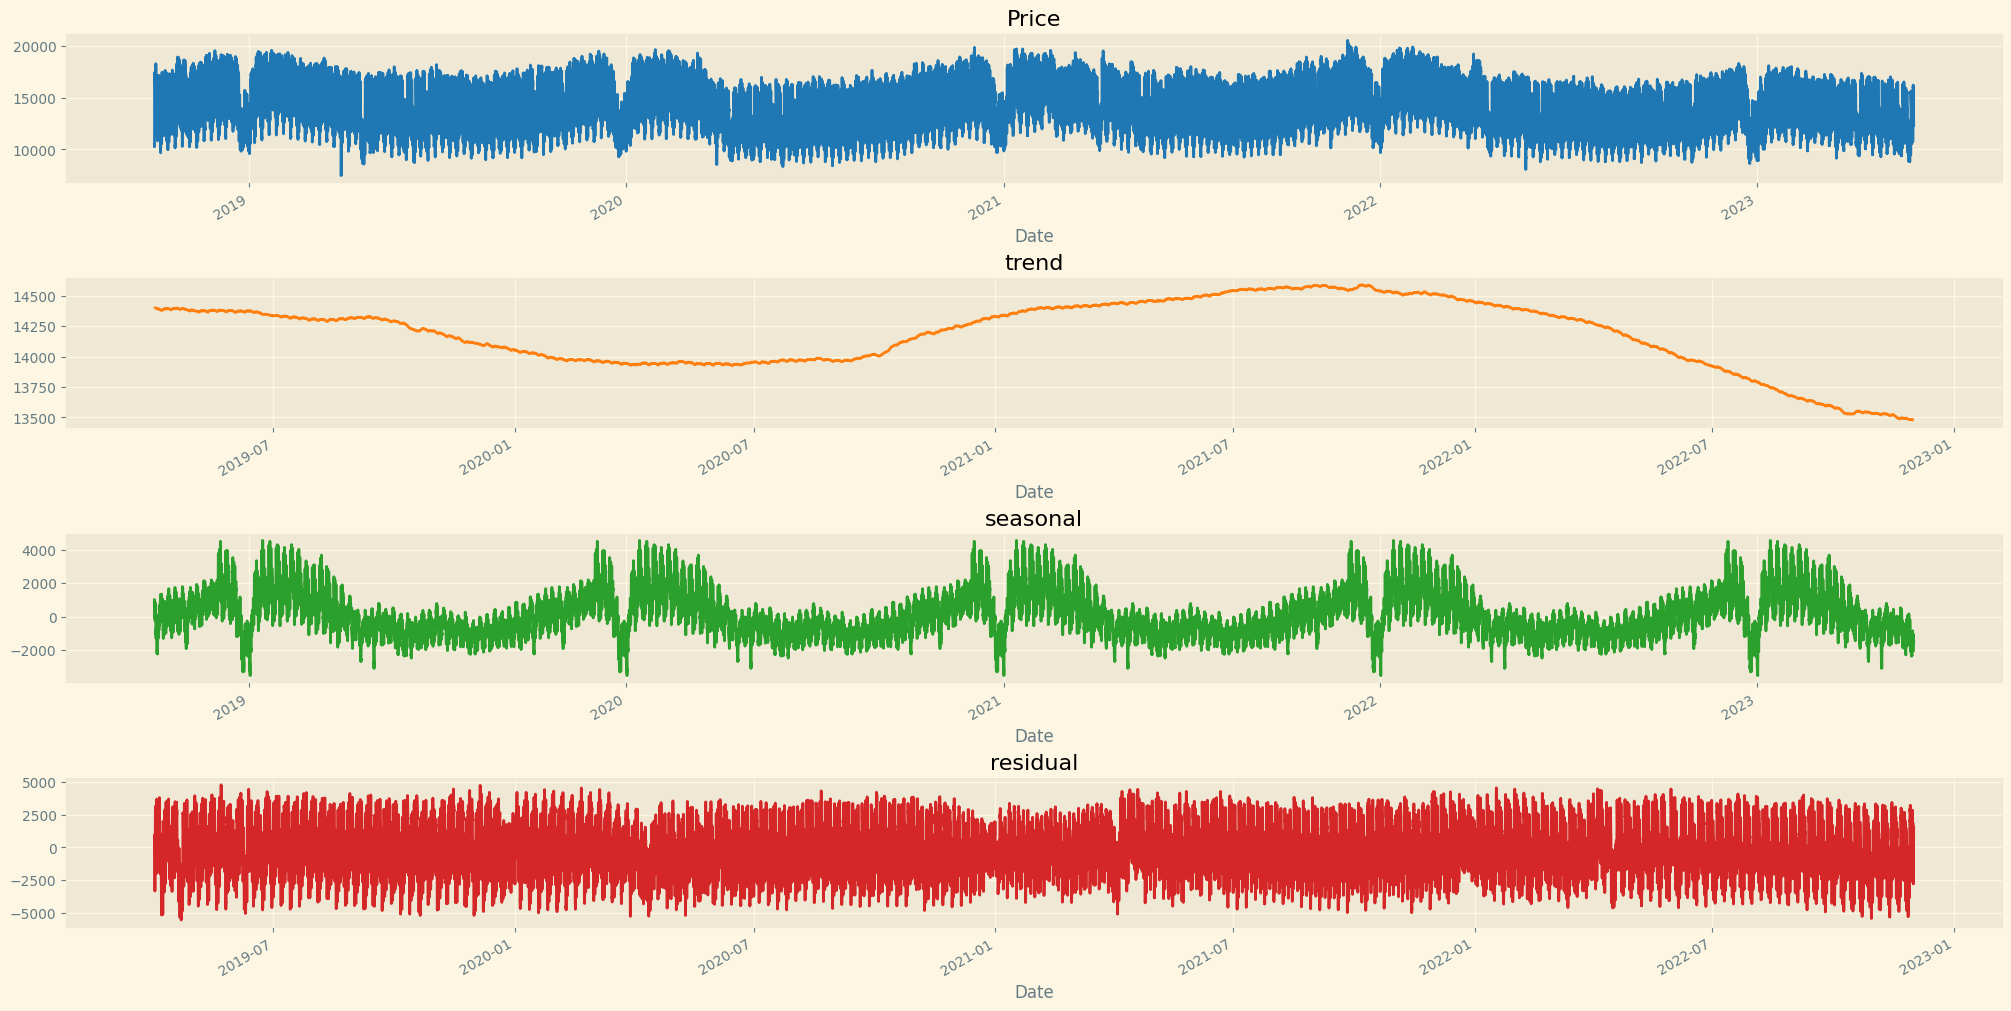

In [7]:
# Check decomposition of trend, seasonality and residue of original time series 
# Checking and confirming whether there normalisation of Solar consumption data /n
# /n changes the visualisation in any way or not
decomposition = seasonal_decompose(x=df['Actual_consumption'], 
                                   model='additive',
                                   period=35064)#4*24*365.25


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Price')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

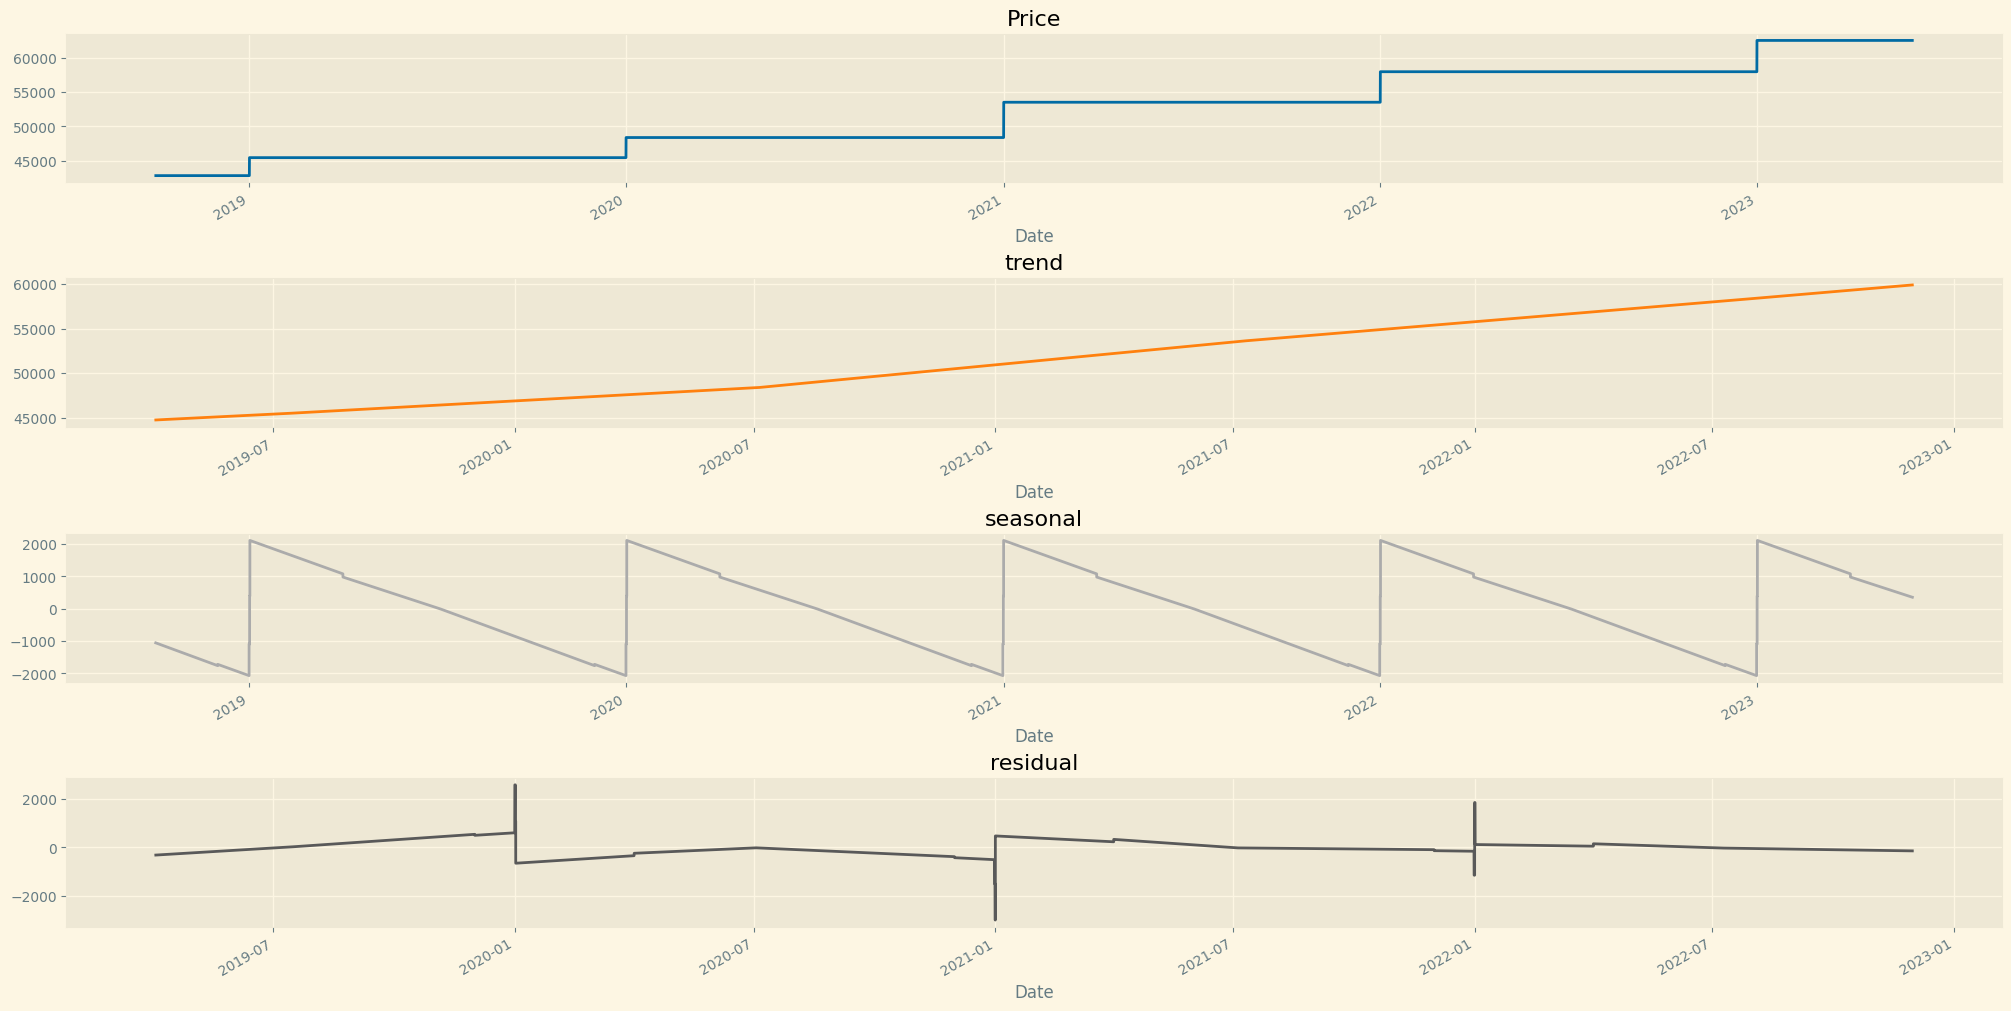

In [18]:
# Check decomposition of trend, seasonality and residue of original time series and Installed solar capacity
decomposition = seasonal_decompose(x=df['Installed_capacity'], 
                                   model='additive',
                                   period=35064)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Price')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163680 entries, 2018-10-01 00:00:00 to 2023-06-01 23:45:00
Data columns (total 6 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Solar_act_consumption            163680 non-null  float64
 1   Installed_capacity               163680 non-null  float64
 2   Actual_consumption               163680 non-null  float64
 3   Price                            163680 non-null  float64
 4   normalisation_factor             163680 non-null  float64
 5   Solar_generation_MWh_normalized  163680 non-null  float64
dtypes: float64(6)
memory usage: 8.7 MB


<Axes: xlabel='Date'>

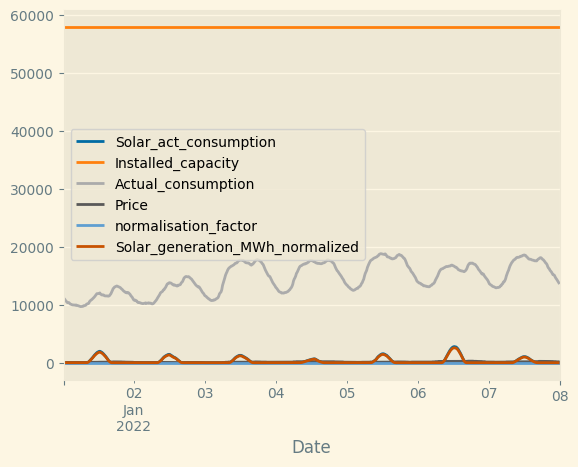

In [20]:
df.loc[(df.index > '01.01.2022') & (df.index <= '01.08.2022')].plot()

# Feature Creation

In [63]:
def create_feature(df):
    df = df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']= df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']= df.index.dayofyear
    df['dayofmonth']= df.index.day
    df['weekofyear']=df.index.isocalendar().week
    df['weekdayname']=df.index.day_name()
    
    return (df)


In [64]:
df =create_feature(df)

In [65]:
df.tail(100)

,Solar_act_consumption,Installed_capacity,Actual_consumption,Price,normalisation_factor,Solar_generation_MWh_normalized,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdayname
Date,,,,,,,,,,,,,,,
2023-05-31 23:00:00,0.0,62579.0,12596.50,83.13,1.0,0.0,23,2,2,5,2023,151,31,22,Wednesday
2023-05-31 23:15:00,0.0,62579.0,12429.75,83.13,1.0,0.0,23,2,2,5,2023,151,31,22,Wednesday
2023-05-31 23:30:00,0.0,62579.0,12227.50,83.13,1.0,0.0,23,2,2,5,2023,151,31,22,Wednesday
2023-05-31 23:45:00,0.0,62579.0,12125.00,83.13,1.0,0.0,23,2,2,5,2023,151,31,22,Wednesday
2023-06-01 00:00:00,0.0,62579.0,11998.75,84.15,1.0,0.0,0,3,2,6,2023,152,1,22,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.0,0.0,22,3,2,6,2023,152,1,22,Thursday
2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.0,0.0,23,3,2,6,2023,152,1,22,Thursday
2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.0,0.0,23,3,2,6,2023,152,1,22,Thursday


<Axes: ylabel='Frequency'>

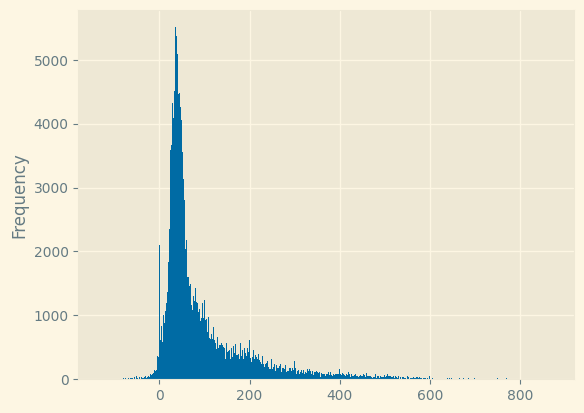

In [24]:
df['Price'].plot(kind='hist', bins = 500)

# Yearly seasonality of Price, Solar generation and Solar consumption

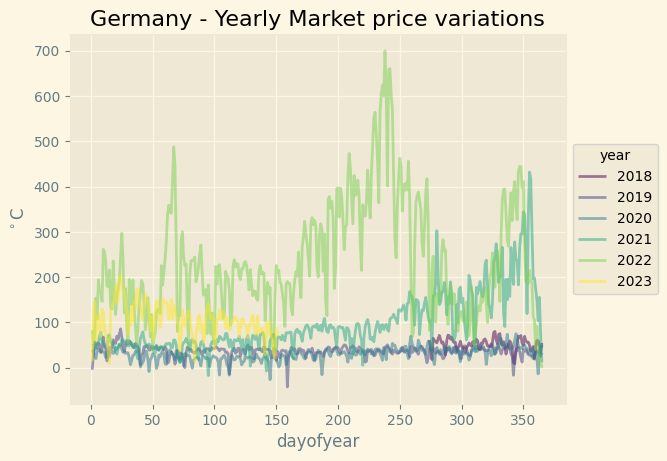

In [25]:
# Plot yearly seasonality of Price
fig, ax = plt.subplots() 

pd.pivot_table(data=df[['year', 'dayofyear', 'Price']], index='dayofyear', columns='year') \
    ['Price'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Germany - Yearly Market price variations', ylabel=r'$^\circ$C');

fig.savefig("images/Germany_yearly_mkt_price.png",dpi=300)

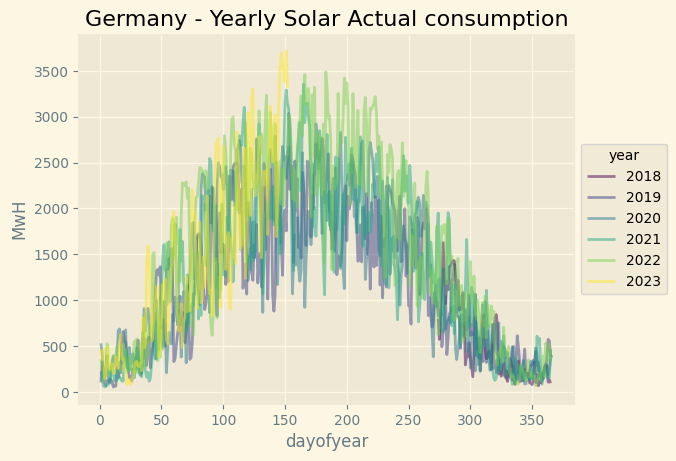

In [85]:
# Plot yearly seasonality of Solar consumption Actual
fig, ax = plt.subplots() 

pd.pivot_table(data=df[['year', 'dayofyear', 'Solar_act_consumption']], index='dayofyear', columns='year') \
    ['Solar_act_consumption'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Germany - Yearly Solar Actual consumption', ylabel='MwH');

fig.savefig("images/Germany_yearly_solar_act_consumption.png",dpi=300)

KeyError: "['year', 'dayofyear'] not in index"

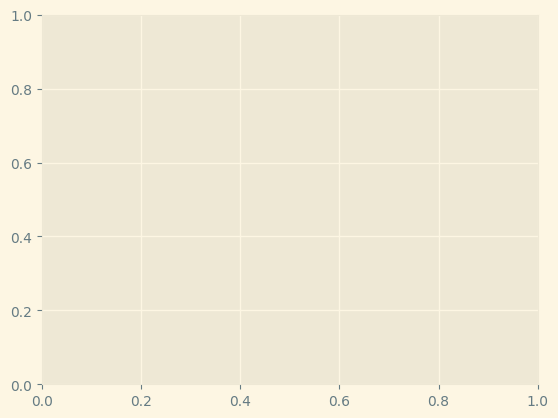

In [8]:
# Plot yearly seasonality of Germany Actual Consumption
fig, ax = plt.subplots() 

pd.pivot_table(data=df[['year', 'dayofyear', 'Actual_consumption']], index='dayofyear', columns='year') \
    ['Actual_consumption'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Germany - Yearly Actual consumption', ylabel='MwH');

fig.savefig("images/Germany_yearly_act_consumption.png",dpi=300)

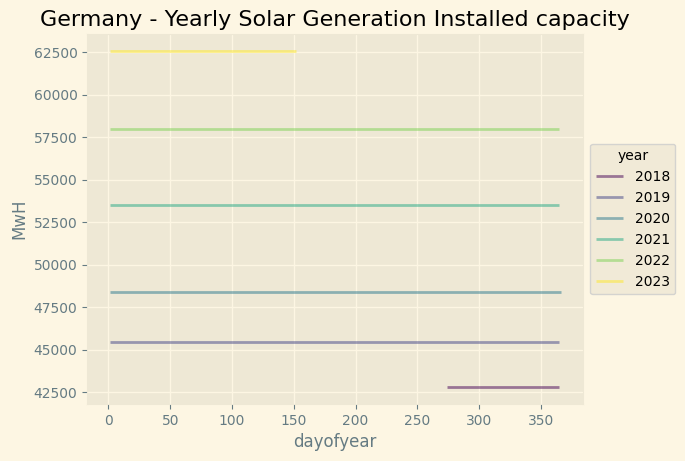

In [27]:
# Plot yearly seasonality of Solar Generation
fig, ax = plt.subplots() 

pd.pivot_table(data=df[['year', 'dayofyear', 'Installed_capacity']], index='dayofyear', columns='year') \
    ['Installed_capacity'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Germany - Yearly Solar Generation capacity', ylabel='MwH');

fig.savefig("images/Germany_yearly_solar_gen_capacity.png",dpi=300)

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -6.540066
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 89.799735
p-value: 0.010000
----------------------------------------


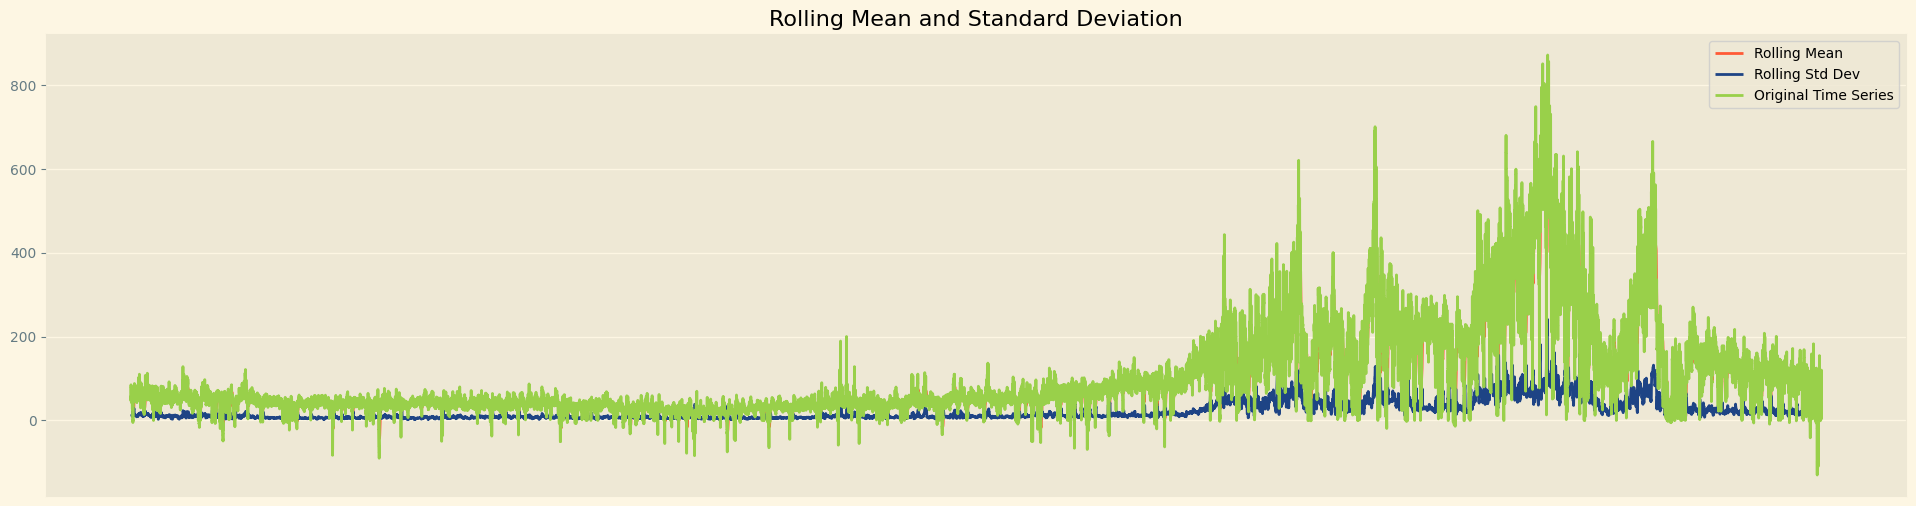

In [28]:
# Test for stationarity 

def stationarity_test(price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = price.rolling(96).mean()
    rolling_std_dev = price.rolling(96).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(price, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df['Price'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -7.170596
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 19.149231
p-value: 0.010000
----------------------------------------


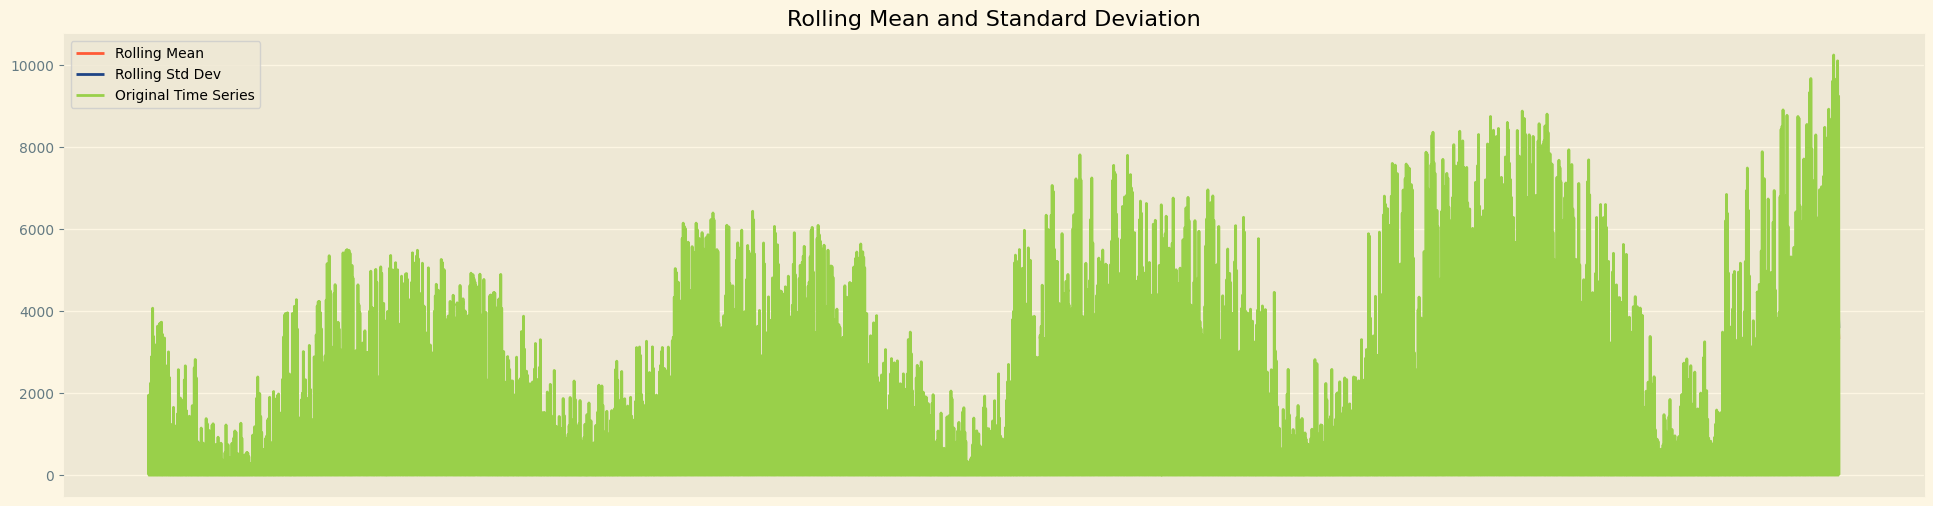

In [29]:
stationarity_test(df['Solar_generation_MWh_normalized'])

In [30]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [31]:
adf_test(df['Price'])
kpss_test(df['Price'])

Results of Dickey-Fuller Test:
Test Statistic                -6.540066e+00
p-value                        9.395243e-09
#Lags Used                     7.600000e+01
Number of Observations Used    1.636030e+05
Critical Value (1%)           -3.430390e+00
Critical Value (5%)           -2.861558e+00
Critical Value (10%)          -2.566779e+00
dtype: float64
Results of KPSS Test:
Test Statistic            31.700435
p-value                    0.010000
Lags Used                231.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


## Visualise Feature/Target relationship

Text(0.5, 1.0, 'Solar consumption/hour')

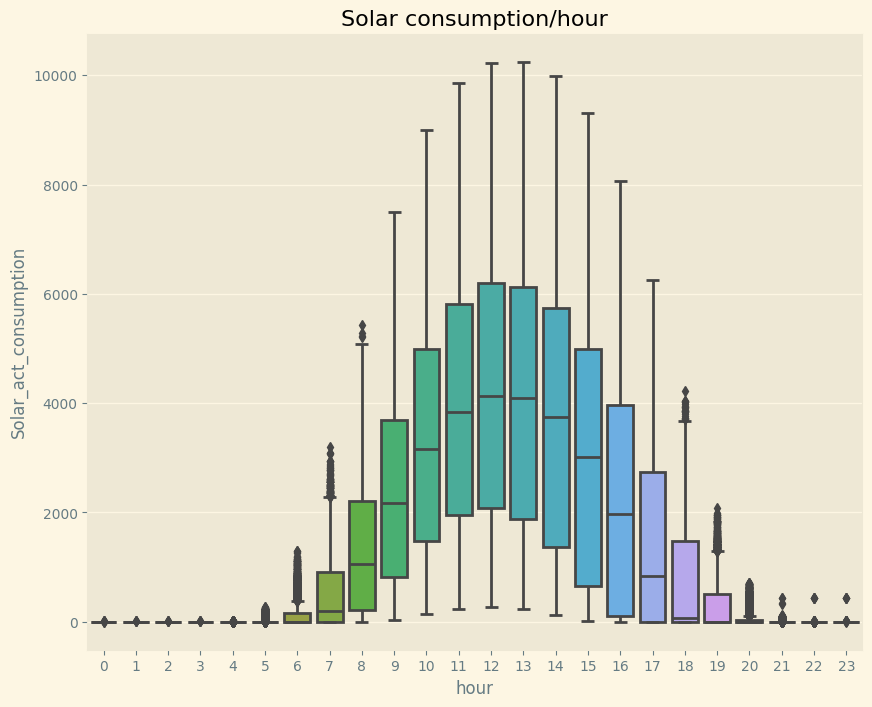

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x='hour', y='Solar_act_consumption')
ax.set_title('Solar consumption/hour')

Text(0.5, 1.0, 'Market Price/hour')

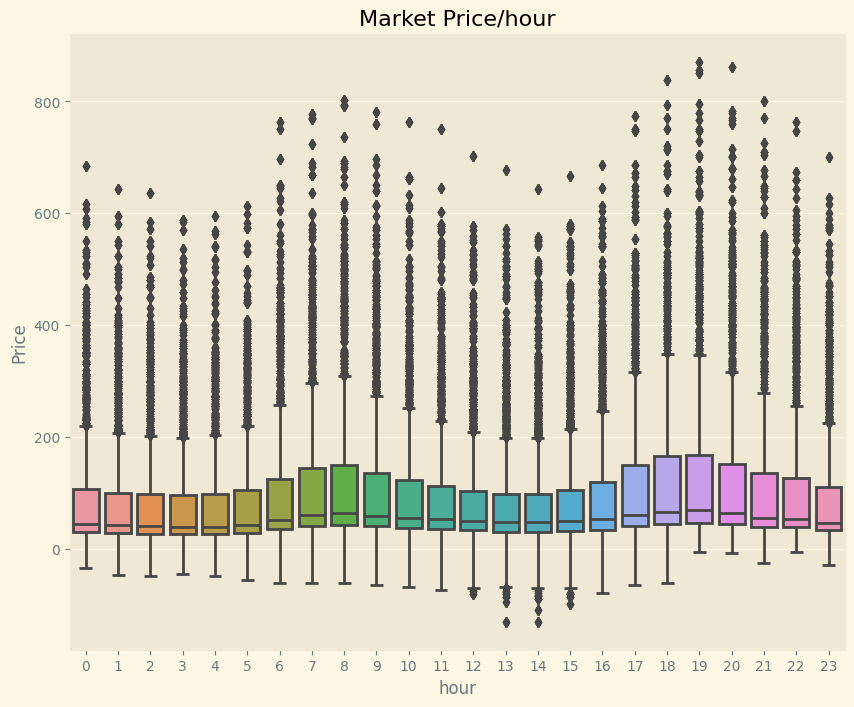

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x='hour', y='Price')
ax.set_title('Market Price/hour')

Text(0.5, 1.0, 'Solar consumption/month')

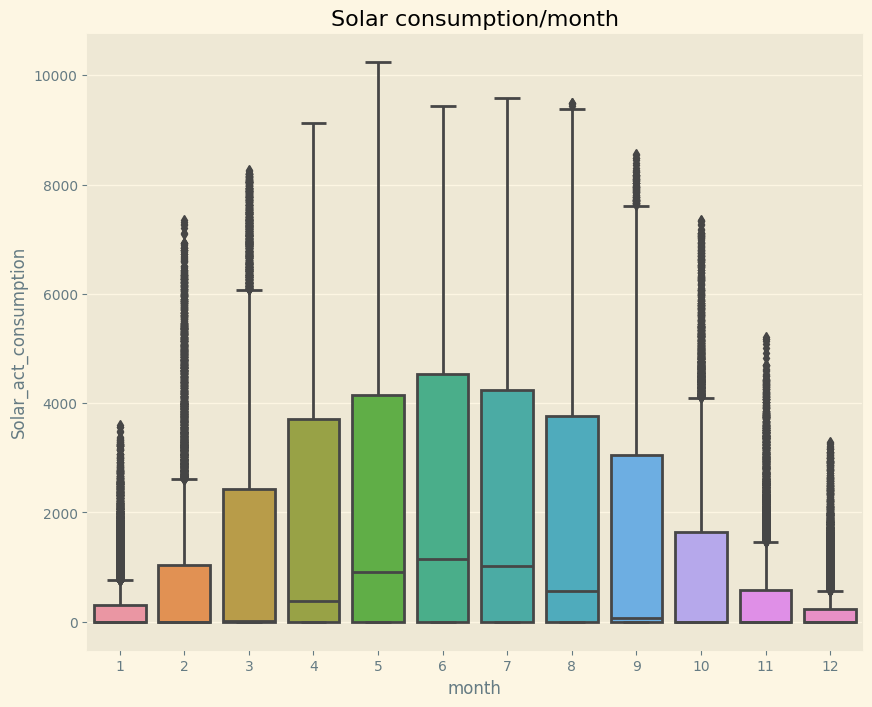

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x='month', y='Solar_act_consumption')
ax.set_title('Solar consumption/month')

Text(0.5, 1.0, 'Market Price/month')

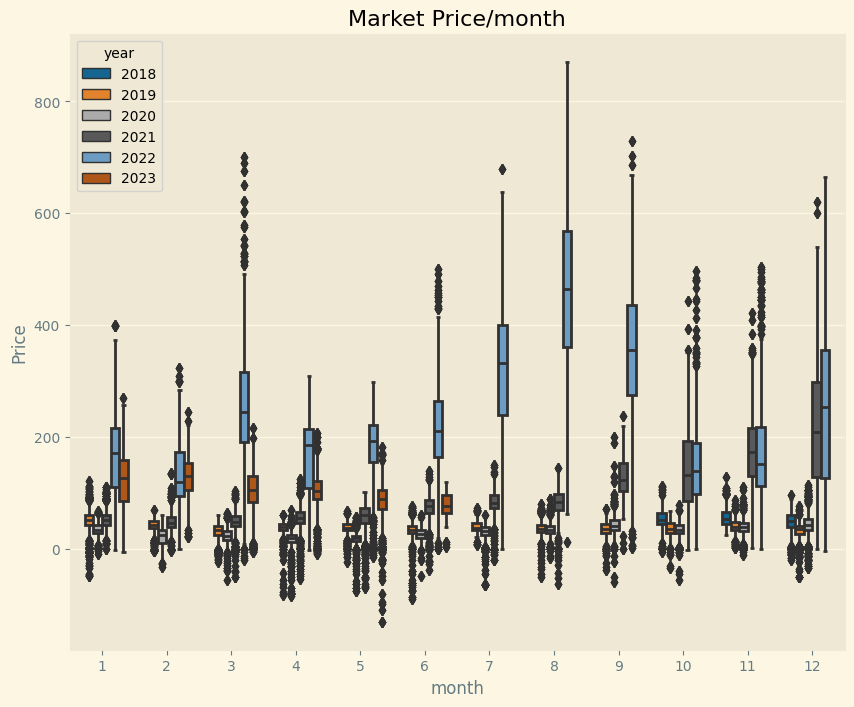

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x='month', y='Price',hue='year')
ax.set_title('Market Price/month')

# simple XGBoost model without Cross validation

In [87]:
data= create_feature(data)
train_cv = create_feature(train_cv)
#val = create_feature(val)
test_cv = create_feature(test_cv)

In [124]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear', 'weekdayname']
TARGET = ['Solar_generation_MWh_normalized']

In [81]:
train_cv.head()

,Solar_act_consumption,Price,Solar_generation_MWh_normalized,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdayname
Date,,,,,,,,,,,,
2018-10-01 00:00:00,0.0,59.53,0.0,0,0,4,10,2018,274,1,40,Monday
2018-10-01 00:15:00,0.0,59.53,0.0,0,0,4,10,2018,274,1,40,Monday
2018-10-01 00:30:00,0.0,59.53,0.0,0,0,4,10,2018,274,1,40,Monday
2018-10-01 00:45:00,0.0,59.53,0.0,0,0,4,10,2018,274,1,40,Monday
2018-10-01 01:00:00,0.0,56.10,0.0,1,0,4,10,2018,274,1,40,Monday


In [125]:
X_train_cv = train_cv[FEATURES]
y_train_cv = train_cv[TARGET]

#X_val = val[FEATURES]
#y_val = val[TARGET]

X_test_cv = test_cv[FEATURES]
y_test_cv = test_cv[TARGET]

## 3. Lag features

In [152]:
target_map = data['Solar_generation_MWh_normalized'].to_dict()
first, *_, last = target_map.items()
print ("last: ", last)

last:  (Timestamp('2023-06-01 23:45:00'), 0.0)


In [146]:
df['lag1']=(df.index - pd.Timedelta( "7 days")).map(target_map)

{Timestamp('2018-10-01 00:00:00'): 0.0,
 Timestamp('2018-10-01 00:15:00'): 0.0,
 Timestamp('2018-10-01 00:30:00'): 0.0,
 Timestamp('2018-10-01 00:45:00'): 0.0,
 Timestamp('2018-10-01 01:00:00'): 0.0,
 Timestamp('2018-10-01 01:15:00'): 0.0,
 Timestamp('2018-10-01 01:30:00'): 0.0,
 Timestamp('2018-10-01 01:45:00'): 0.0,
 Timestamp('2018-10-01 02:00:00'): 0.0,
 Timestamp('2018-10-01 02:15:00'): 0.0,
 Timestamp('2018-10-01 02:30:00'): 0.0,
 Timestamp('2018-10-01 02:45:00'): 0.0,
 Timestamp('2018-10-01 03:00:00'): 0.0,
 Timestamp('2018-10-01 03:15:00'): 0.0,
 Timestamp('2018-10-01 03:30:00'): 0.0,
 Timestamp('2018-10-01 03:45:00'): 0.0,
 Timestamp('2018-10-01 04:00:00'): 0.0,
 Timestamp('2018-10-01 04:15:00'): 0.0,
 Timestamp('2018-10-01 04:30:00'): 0.0,
 Timestamp('2018-10-01 04:45:00'): 0.0,
 Timestamp('2018-10-01 05:00:00'): 0.0,
 Timestamp('2018-10-01 05:15:00'): 0.0,
 Timestamp('2018-10-01 05:30:00'): 0.0,
 Timestamp('2018-10-01 05:45:00'): 0.0,
 Timestamp('2018-10-01 06:00:00'): 0.0,


In [183]:
def add_lags(df):
    df['lag1']=(df.index - pd.Timedelta( "182 days")).map(target_map)
    df['lag2']=(df.index - pd.Timedelta("364 days")).map(target_map)
    df['lag3']=(df.index - pd.Timedelta("546 days")).map(target_map)
    return (df)

In [184]:
data = add_lags(data)

In [185]:
data.loc[data['lag3']==0.]

,Solar_act_consumption,Price,Solar_generation_MWh_normalized,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdayname,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
2020-03-30 00:00:00,0.0,18.10,0.0,0,0,1,3,2020,90,30,14,Monday,0.0,0.0,0.0
2020-03-30 00:15:00,0.0,18.10,0.0,0,0,1,3,2020,90,30,14,Monday,0.0,0.0,0.0
2020-03-30 00:30:00,0.0,18.10,0.0,0,0,1,3,2020,90,30,14,Monday,0.0,0.0,0.0
2020-03-30 00:45:00,0.0,18.10,0.0,0,0,1,3,2020,90,30,14,Monday,0.0,0.0,0.0
2020-03-30 01:00:00,0.0,17.81,0.0,1,0,1,3,2020,90,30,14,Monday,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 22:45:00,0.0,95.41,0.0,22,3,2,6,2023,152,1,22,Thursday,0.0,0.0,0.0
2023-06-01 23:00:00,0.0,86.53,0.0,23,3,2,6,2023,152,1,22,Thursday,0.0,0.0,0.0
2023-06-01 23:15:00,0.0,86.53,0.0,23,3,2,6,2023,152,1,22,Thursday,0.0,0.0,0.0


In [187]:
df_lag4 = pd.DataFrame((df.index - pd.Timedelta( "182 days")).map(target_map))
df_lag4.loc[df_lag4['Date']!=0. &amp]

,Date
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
163646,75.539127
163647,30.586395
163648,8.110029
163649,1.158576


In [116]:
df.index - pd.Timedelta("2 days")

DatetimeIndex(['2018-09-29 00:00:00', '2018-09-29 00:15:00',
               '2018-09-29 00:30:00', '2018-09-29 00:45:00',
               '2018-09-29 01:00:00', '2018-09-29 01:15:00',
               '2018-09-29 01:30:00', '2018-09-29 01:45:00',
               '2018-09-29 02:00:00', '2018-09-29 02:15:00',
               ...
               '2023-05-30 21:30:00', '2023-05-30 21:45:00',
               '2023-05-30 22:00:00', '2023-05-30 22:15:00',
               '2023-05-30 22:30:00', '2023-05-30 22:45:00',
               '2023-05-30 23:00:00', '2023-05-30 23:15:00',
               '2023-05-30 23:30:00', '2023-05-30 23:45:00'],
              dtype='datetime64[ns]', name='Date', length=163680, freq=None)

In [112]:
data.tail(200)

,Solar_act_consumption,Price,Solar_generation_MWh_normalized,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdayname,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
2023-05-30 22:00:00,0.0,97.31,0.0,22,1,2,5,2023,150,30,22,Tuesday,NaN,NaN,NaN
2023-05-30 22:15:00,0.0,97.31,0.0,22,1,2,5,2023,150,30,22,Tuesday,NaN,NaN,NaN
2023-05-30 22:30:00,0.0,97.31,0.0,22,1,2,5,2023,150,30,22,Tuesday,NaN,NaN,NaN
2023-05-30 22:45:00,0.0,97.31,0.0,22,1,2,5,2023,150,30,22,Tuesday,NaN,NaN,NaN
2023-05-30 23:00:00,0.0,89.65,0.0,23,1,2,5,2023,150,30,22,Tuesday,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 22:45:00,0.0,95.41,0.0,22,3,2,6,2023,152,1,22,Thursday,NaN,NaN,NaN
2023-06-01 23:00:00,0.0,86.53,0.0,23,3,2,6,2023,152,1,22,Thursday,NaN,NaN,NaN
2023-06-01 23:15:00,0.0,86.53,0.0,23,3,2,6,2023,152,1,22,Thursday,NaN,NaN,NaN


In [77]:
reg_cv = XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,learning_rate = 0.01)
reg_cv.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv,y_test_cv)],verbose=100)


[0]	validation_0-rmse:1499.23009	validation_1-rmse:1918.23554
[100]	validation_0-rmse:896.46011	validation_1-rmse:1164.05926
[200]	validation_0-rmse:673.70339	validation_1-rmse:872.60305
[300]	validation_0-rmse:605.43263	validation_1-rmse:768.28607
[400]	validation_0-rmse:588.94452	validation_1-rmse:732.44484
[500]	validation_0-rmse:587.67441	validation_1-rmse:717.41378
[600]	validation_0-rmse:590.05649	validation_1-rmse:713.19673
[700]	validation_0-rmse:593.34816	validation_1-rmse:711.57828
[745]	validation_0-rmse:594.99604	validation_1-rmse:711.62591


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Simple XGB model with cross validation

In [ ]:
train = create_feature(train)
val = create_feature(val)
test = create_feature(test)

In [117]:
FEATURES

['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']